In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
from helper_functions.arma_helper_functions import *
from helper_functions.comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./data/train_data.npy')
y = np.load('./data/actual_train_labels.npy')
X_test = np.load('./data/test_data.npy')

train_data = pd.read_pickle('./data/train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  492


### Visualize data to assess stationarity
The moments (mean and variance) of a stationary process are independent of time (remain constant). From the following plots we can safely assume that the assumption of stationarity holds, hence no differencing is required.

Text(0.5, 0, 'Day')

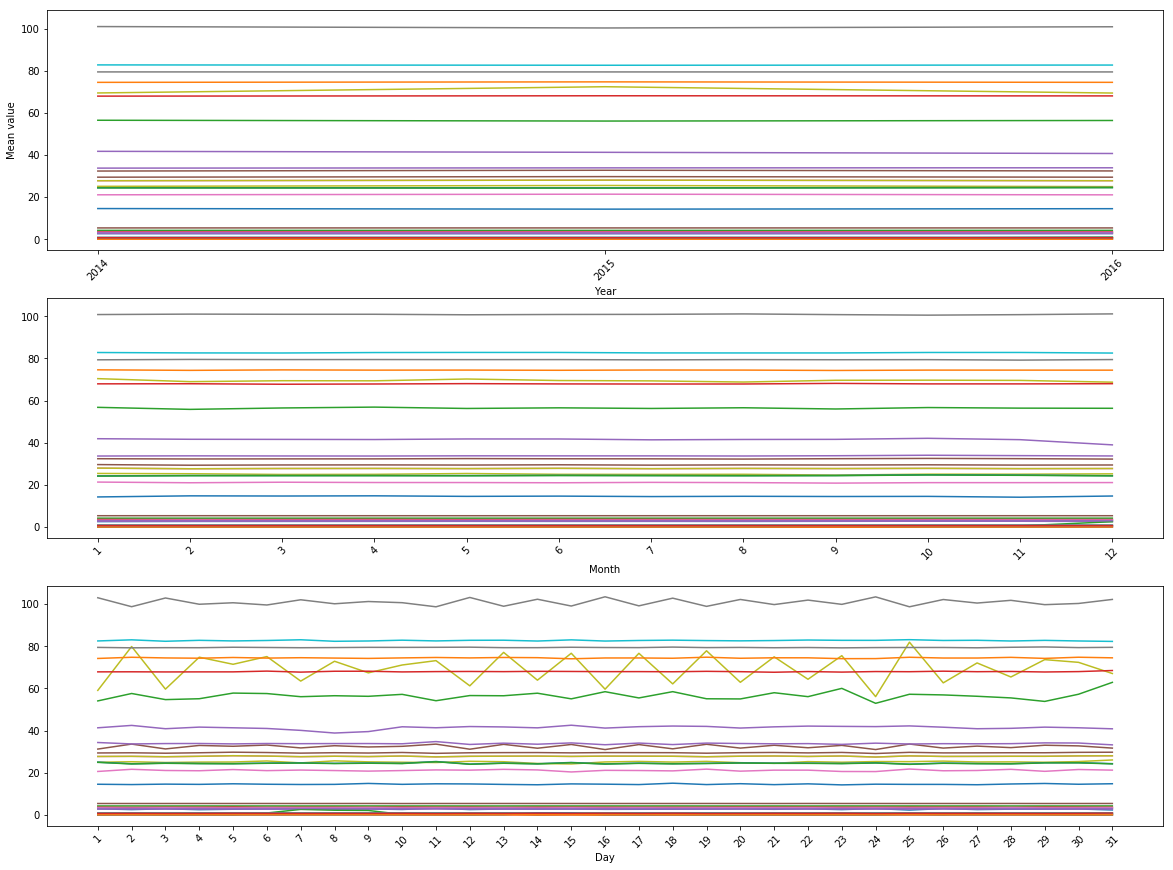

In [2]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Year','Day', 'Hour'], axis=1).groupby(['Month']).mean()
mean_daily = train_data.drop(['Month', 'Year', 'Hour'], axis=1).groupby('Day').mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")

Text(0.5, 0, 'Day')

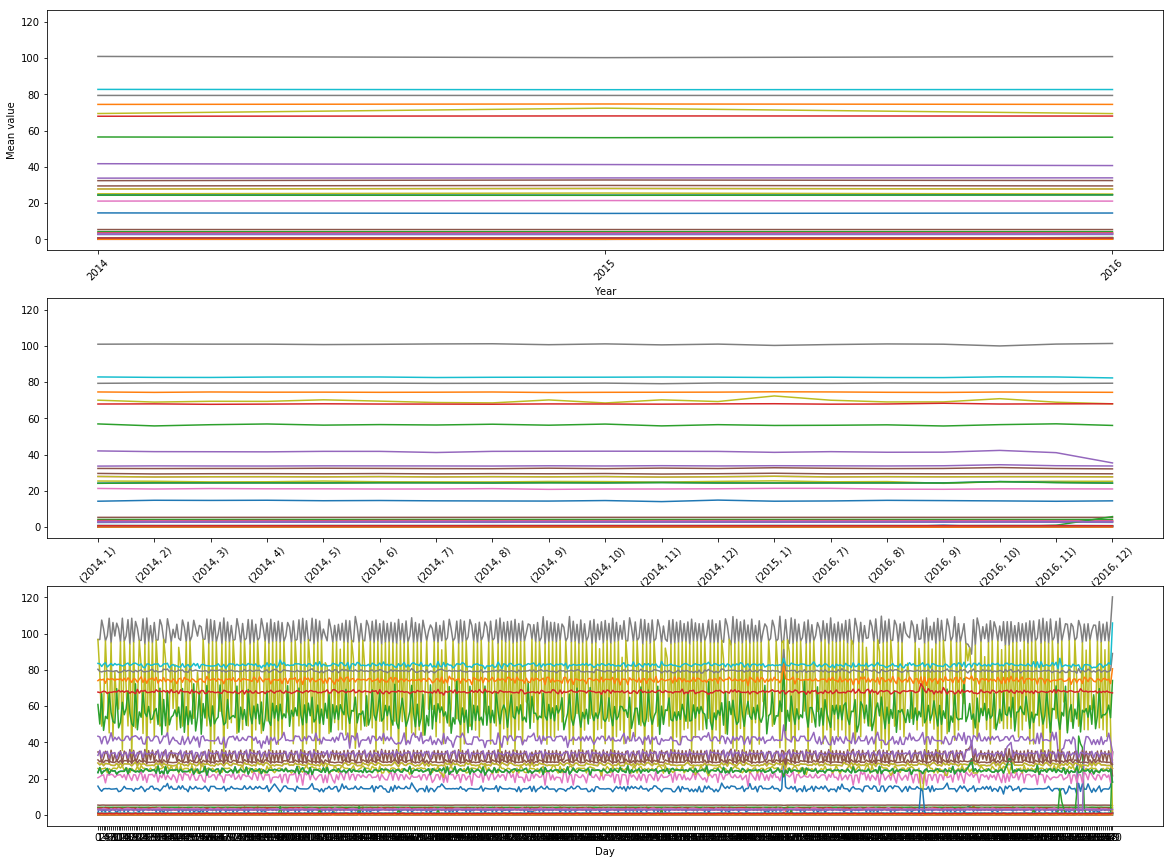

In [2]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Day', 'Hour'], axis=1).groupby(['Year', 'Month']).mean()
mean_daily = train_data.drop(['Hour'], axis=1).groupby(['Year','Month','Day']).mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
# ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")


### ARMA

First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1[:, 0]
test_signal = X2[:, 0]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  -558.1004639865932
BIC:  -536.8662679885941
DW-test:  0.29607800631926867


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

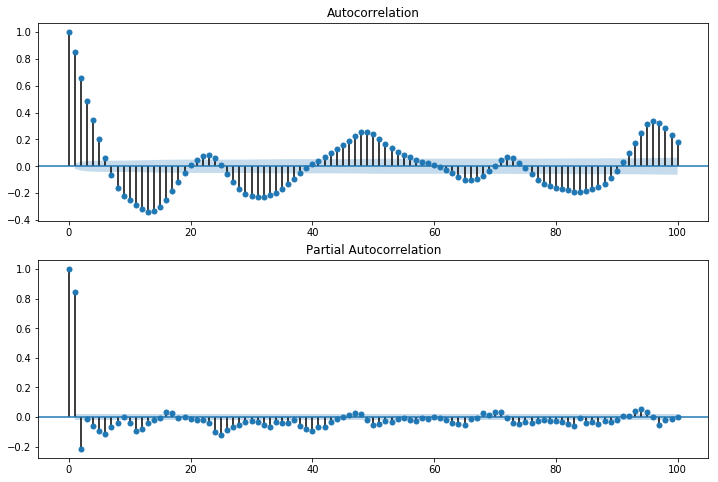

In [3]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [4]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

threshold = 1000

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q, threshold)

print(AIC)
print(f"Best model fit with order ({p[opt_p]}, {q[opt_q]}), with AIC: {AIC[opt_p, opt_q]}")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[[  -558.10046399  -7752.45563747 -10576.71180809 -11778.8607375
  -12257.7459319  -12529.47134618]
 [-13038.32369885 -13266.3361316  -13286.6920445  -13301.27388589
  -13300.32781029 -13313.07988654]
 [-13229.08776035 -13277.96850542 -13412.40501492 -13411.24287303
  -13411.15681665 -13409.89791558]
 [-13302.66008756 -13386.80851031 -13411.09456864 -13410.96433962
  -13409.23348391 -13340.82570028]
 [-13306.70654695 -13413.79224632 -13402.24940629 -13409.32865291
  -13531.22590249 -13542.48662007]]
Best model fit with order (2, 0), with AIC: -13038.323698849712


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Fit optimal model

In [5]:
# summary of the fitted model
opt_p, opt_q = 2,0
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(2, 0)   Log Likelihood                6523.162
Method:                       css-mle   S.D. of innovations              0.115
Date:                Wed, 29 May 2019   AIC                         -13038.324
Time:                        13:27:22   BIC                         -13010.011
Sample:                             0   HQIC                        -13028.677
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6760      0.034     78.181      0.000       2.609       2.743
ar.L1.y        1.8357      0.005    350.633      0.000       1.825       1.846
ar.L2.y       -0.8715      0.005   -166.440      0.0

Max:  2.166314199396119
Mean:  -0.00019811791253706332
std:  0.11717553687496611


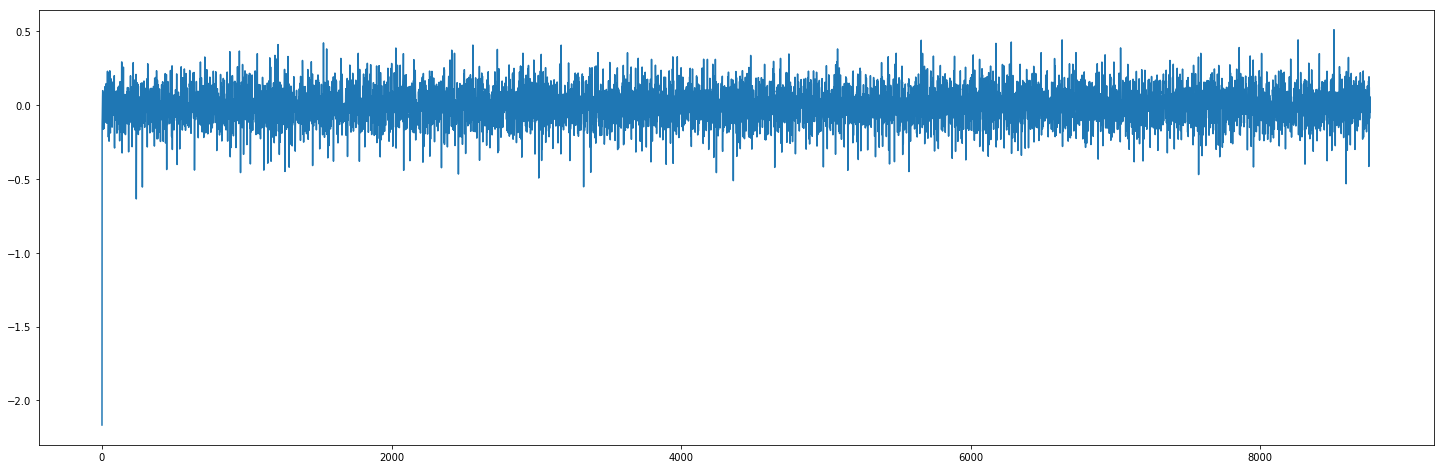

In [6]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [8]:
file = './data/arma_21_LT1.npy'
# opt_p, opt_q = 5,5
predictions, MFE, MAE = predict_mini(train_signal, test_signal, opt_p, opt_q,
                                file=file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)

MFE:  0.09605359882928097
MAE:  0.2822016131810604


Text(0, 0.5, 'L_T1')

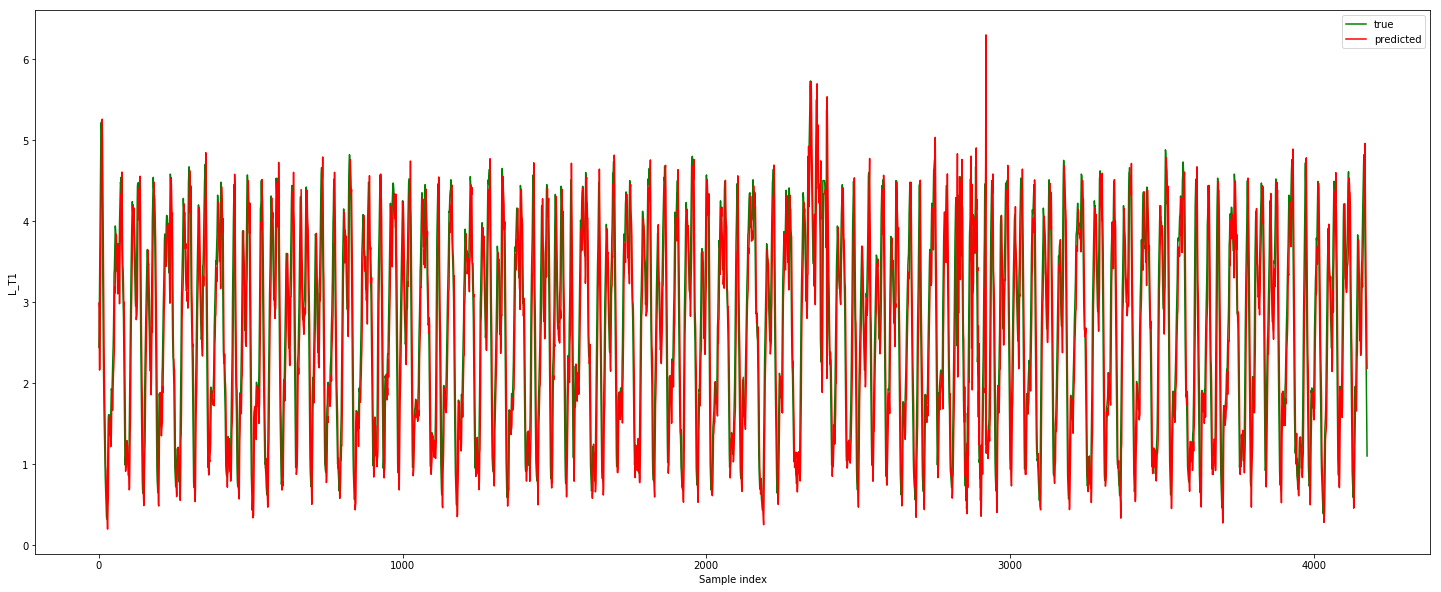

In [9]:
plt.figure(figsize=(25,10))
plt.plot(X2[:, 0], color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

In [16]:
multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.08
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.53956436 0.53963058 0.53944714 0.53365777 0.53816943 0.53987367
 0.54056773 0.52238791 0.52713503 0.5181761  0.5285131  0.53898318
 0.53273751 0.5397782  0.52672448 0.48948186 0.46667355] 

ind:  6


Confusion matrix:  [[ 433 3233]
 [  59  452]] 

SCM:  0.5013703654675624
Sttd:  0.9913373860182371
Score:  0.5405677271116164
Accuracy:  0.21187455111323916
Precision:  0.11811238406983088
Recall:  0.8800813008130082
F1_score:  0.2082732082732083


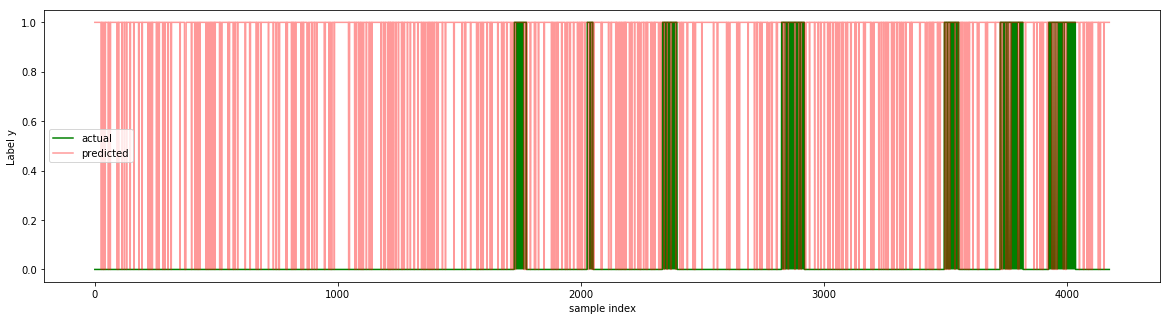

In [17]:
threshold_up, threshold_down = determine_threshold(X1[:, 0], opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(X2[:, 0], predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix: ", cm, "\n")

scm = compute_scm(cm)
print("SCM: ", scm)

sttd = compute_sttd(y2, predicted_labels)
print("Sttd: ", sttd)

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: ", s)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

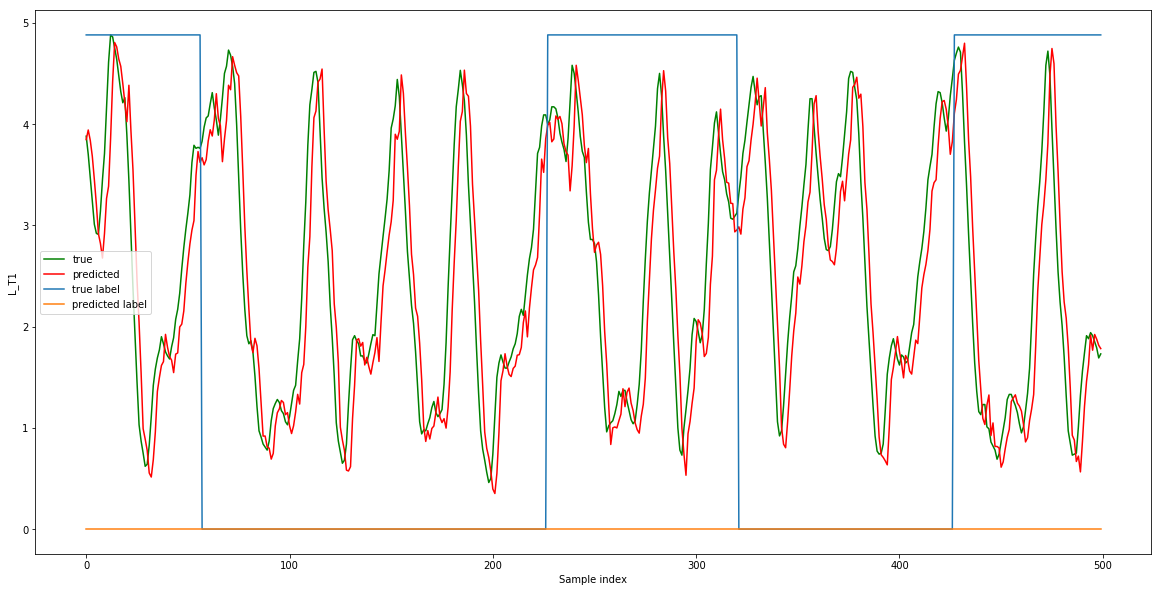

In [55]:
plt.figure(figsize=(20,10))
plt.plot(X2[3500:4000, 0], color = 'g', label='true')
plt.plot(predictions[3500:4000], color='r', label='predicted')
plt.plot(y2[3500:4000]*max(X2[3500:4000, 0]), label='true label')
plt.plot(predicted_labels[3500:4000]*max(X2[3500:4000, 0]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: L_T2
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

train_signal = X1[:, 1]
test_signal = X2[:, 1]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  11081.936237788097
BIC:  11103.170433786096
DW-test:  0.3887363503777569


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

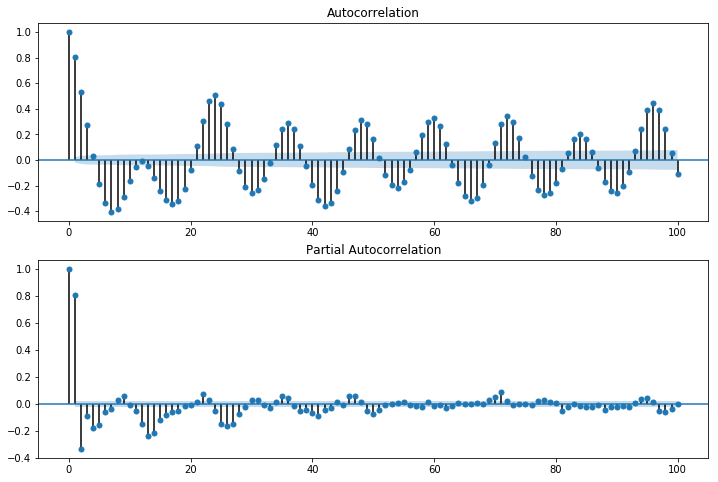

In [6]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [7]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

threshold = 1000

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q, threshold)

print(AIC)
print(f"Best model fit with order ({p[opt_p]}, {q[opt_q]}), with AIC: {AIC[opt_p, opt_q]}")

Failed to fit ARMA model (3, 3)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Failed to fit ARMA model (4, 5)
[[11081.93623779  4485.75745224  1977.71600397  1190.67544385
    633.49368201   337.35506027]
 [  -15.63695161  -206.84170932  -221.13727672  -219.31648392
   -275.97170864  -338.3147054 ]
 [ -180.44168683  -218.819148    -316.31059877  -314.33290467
   -440.08534051  -500.7968714 ]
 [ -216.97404448  -306.64927588  -314.34416197     0.
  -1827.76748609 -1871.92154119]
 [ -230.95274033  -307.63895339  -585.66186918 -1362.97211881
  -1858.41940028     0.        ]]
Best model fit with order (4, 4), with AIC: -1827.7674860924235


#### Fit optimal model

In [8]:
# summary of the fitted model
# opt_p, opt_q = 4,4
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(3, 4)   Log Likelihood                 229.043
Method:                       css-mle   S.D. of innovations              0.236
Date:                Wed, 29 May 2019   AIC                           -440.085
Time:                        13:47:57   BIC                           -376.383
Sample:                             0   HQIC                          -418.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2855      0.045     72.441      0.000       3.197       3.374
ar.L1.y        2.3938      0.028     85.847      0.000       2.339       2.448
ar.L2.y       -2.1010      0.052    -40.571      0.0

Max:  1.2364945546909043
Mean:  -7.776535311177112e-05
std:  0.23602142470988716


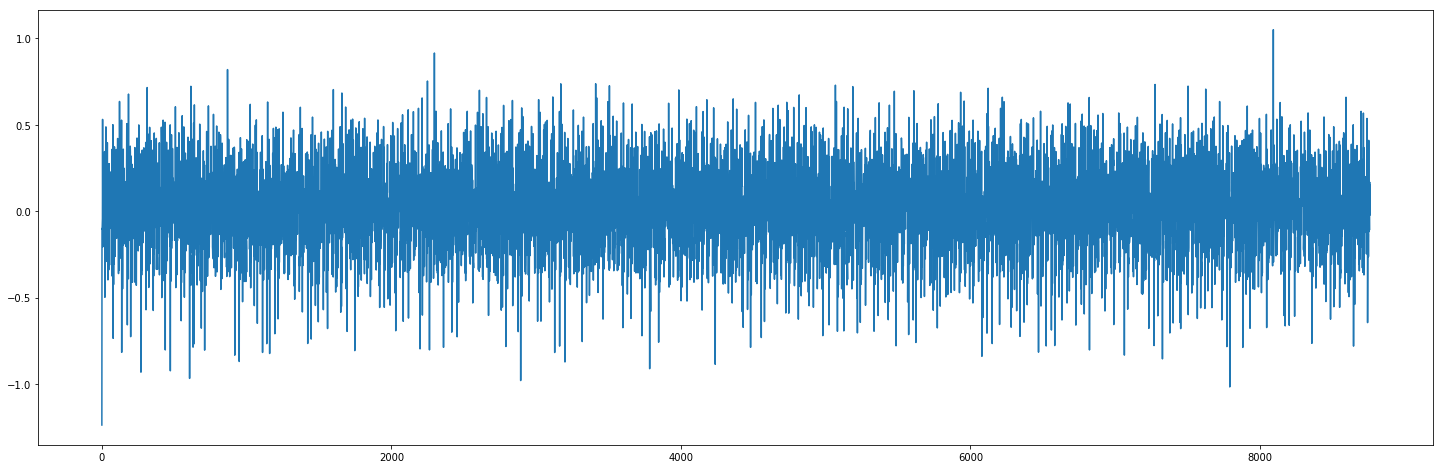

In [9]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [10]:
file = './data/arma_44_LT2.npy'
predictions, MFE, MAE = predict_mini(train_signal, test_signal, opt_p, opt_q,
                                file=file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)

MFE:  0.1808168767504015
MAE:  0.38568849260656207


Text(0, 0.5, 'L_T1')

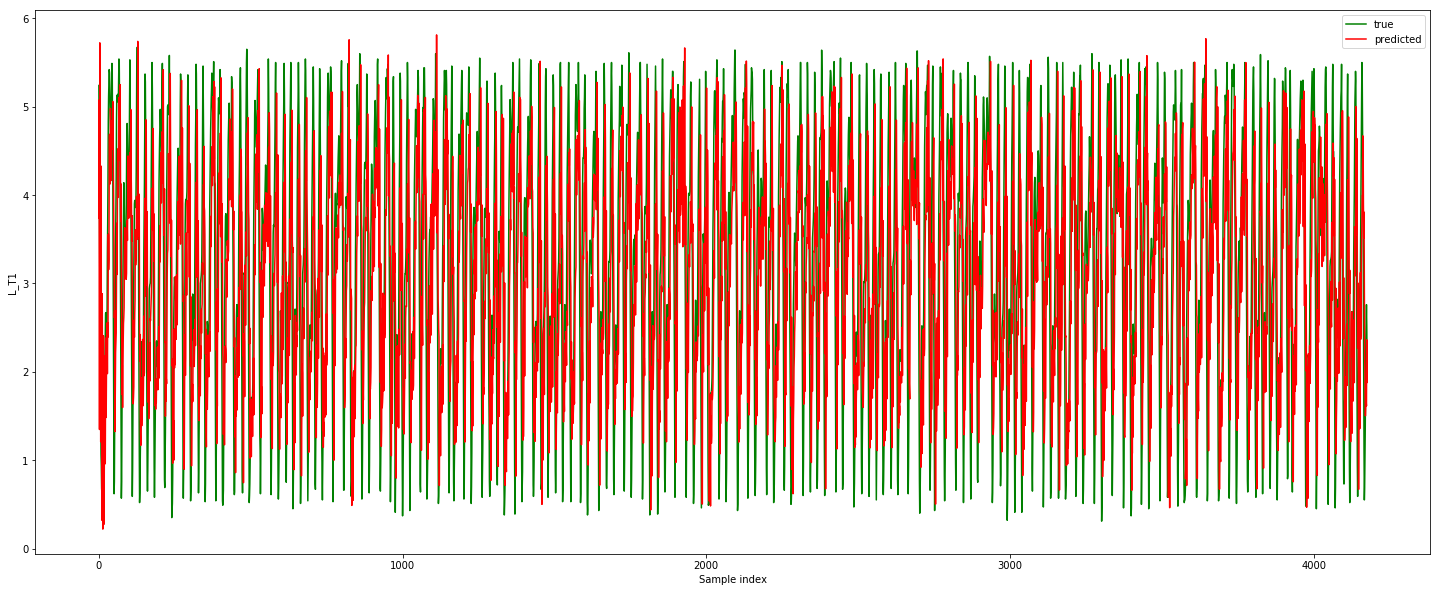

In [14]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

In [18]:
multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.05
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.52442126 0.52674147 0.52294806 0.52301906 0.52870905 0.52931399
 0.52748166 0.53818018 0.53491521 0.52756764 0.52534311 0.51515666
 0.50350076 0.50602231 0.49739487 0.49528455 0.475     ] 

ind:  7


Confusion matrix:  [[ 384 2772]
 [ 108  913]] 

SCM:  0.5141244994539498
Sttd:  0.9952380952380953
Score:  0.538180179243157
Accuracy:  0.31050993536030647
Precision:  0.12167300380228137
Recall:  0.7804878048780488
F1_score:  0.21052631578947367


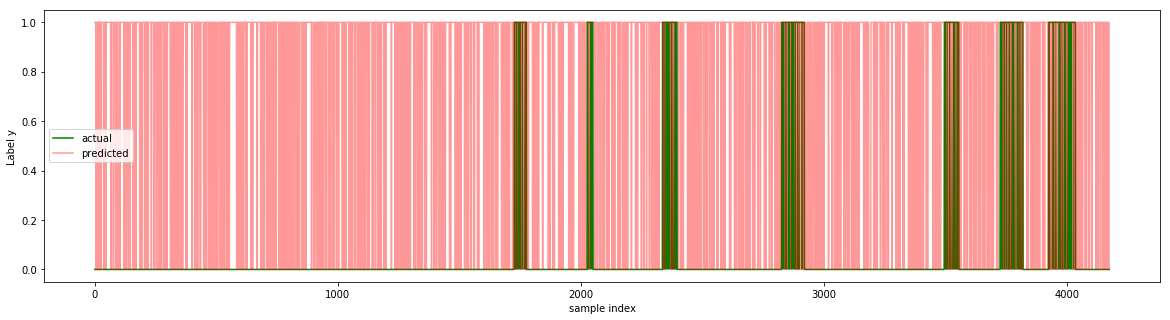

In [19]:
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix: ", cm, "\n")

scm = compute_scm(cm)
print("SCM: ", scm)

sttd = compute_sttd(y2, predicted_labels)
print("Sttd: ", sttd)

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: ", s)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

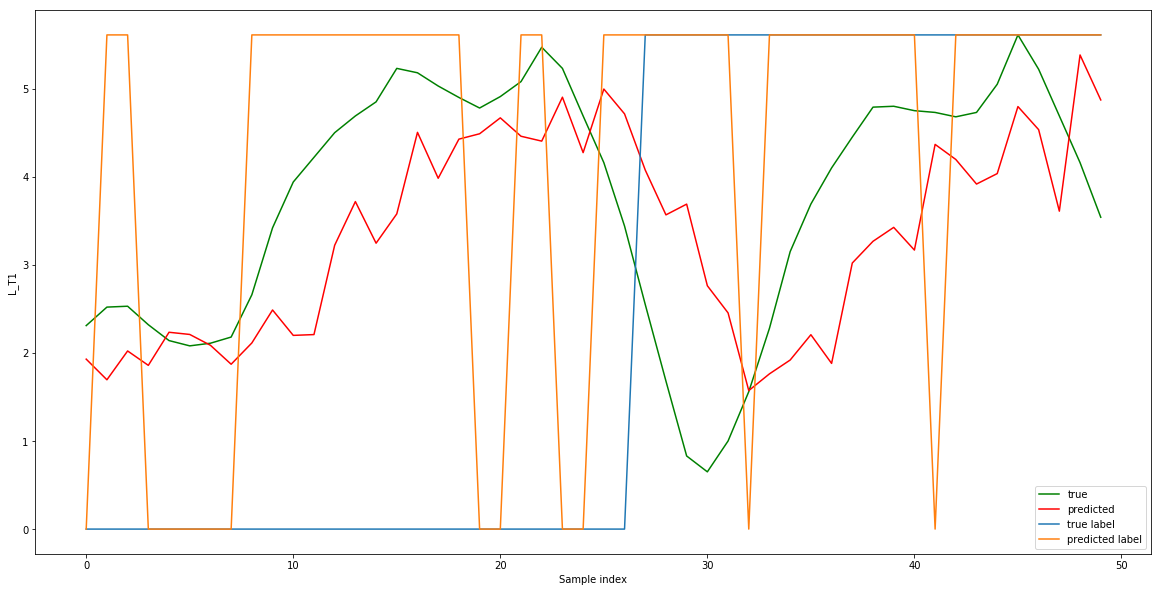

In [24]:
start = 1700
end = 1750

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: F_PU1
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

train_signal = X1[:, 5]
test_signal = X2[:, 5]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  -9261.87852760401
BIC:  -9240.644331606012
DW-test:  1.3631004419829589


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

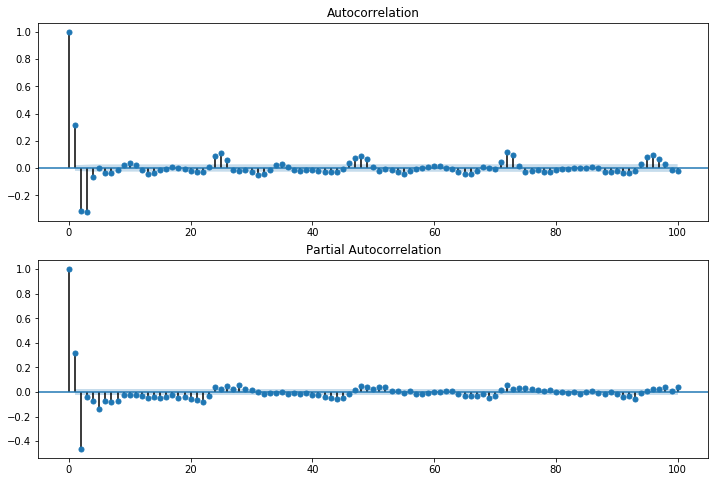

In [37]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [38]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

threshold = 1000

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q, threshold)

print(AIC)
print(f"Best model fit with order ({p[opt_p]}, {q[opt_q]}), with AIC: {AIC[opt_p, opt_q]}")

[[ -9261.8785276  -11783.81460087 -12284.18292272 -12707.59114812
  -12790.21128295 -12794.87310142]
 [-12212.71522494 -12499.9150116  -12509.16355513 -12773.5598685
  -12794.38907921 -12792.88356161]
 [-12450.74677108 -12499.25070049 -12702.55819678 -12788.2733883
  -12792.99156006 -12791.00356205]
 [-12566.38498846 -12762.36880562 -12765.83983145 -12793.2065813
  -12791.41496981 -12789.50217214]
 [-12667.02354453 -12768.61414343 -12773.41499683 -12791.41337813
  -12789.61949408 -12825.91596553]]
Best model fit with order (1, 4), with AIC: -12790.211282951434


#### Fit optimal model

In [39]:
# summary of the fitted model
opt_p, opt_q = 1,2
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(1, 2)   Log Likelihood                6147.091
Method:                       css-mle   S.D. of innovations              0.120
Date:                Wed, 29 May 2019   AIC                         -12284.183
Time:                        14:05:27   BIC                         -12248.793
Sample:                             0   HQIC                        -12272.124
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3704      0.003   1725.119      0.000       5.364       5.377
ar.L1.y       -0.0370      0.021     -1.740      0.082      -0.079       0.005
ma.L1.y        1.0772      0.018     59.224      0.0

Max:  0.4776341010138739
Mean:  7.262520175468392e-06
std:  0.11995759234120994


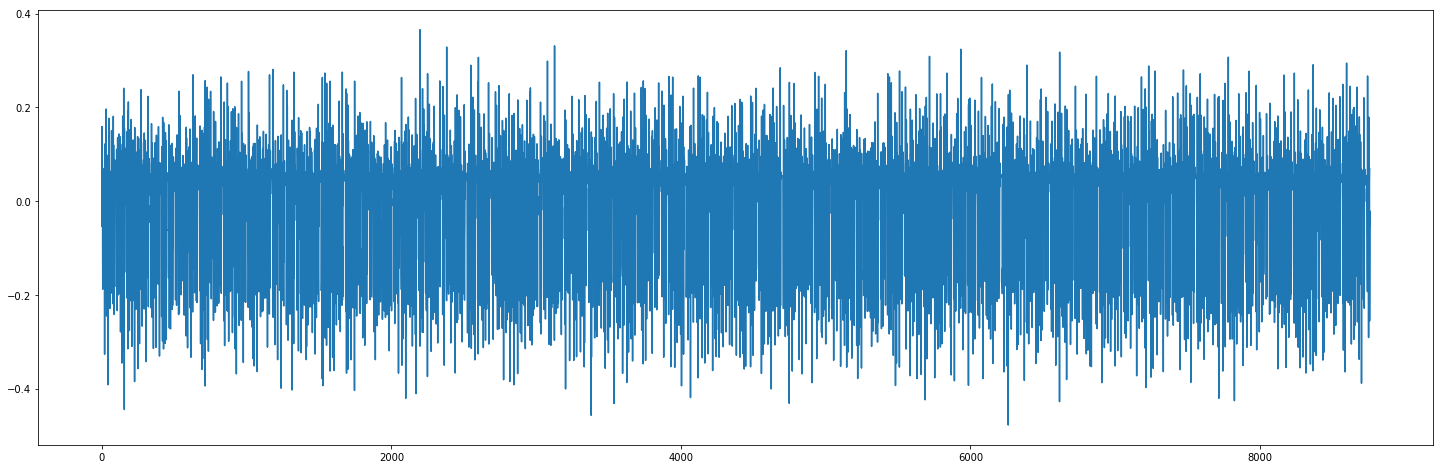

In [40]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [41]:
file = './data/arma_12_LT6.npy'
predictions, MFE, MAE = predict_mini(train_signal, test_signal, opt_p, opt_q,
                                file=file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)

MFE:  -1.597192640921952e+64
MAE:  1.0721305836321677


Text(0, 0.5, 'L_T1')

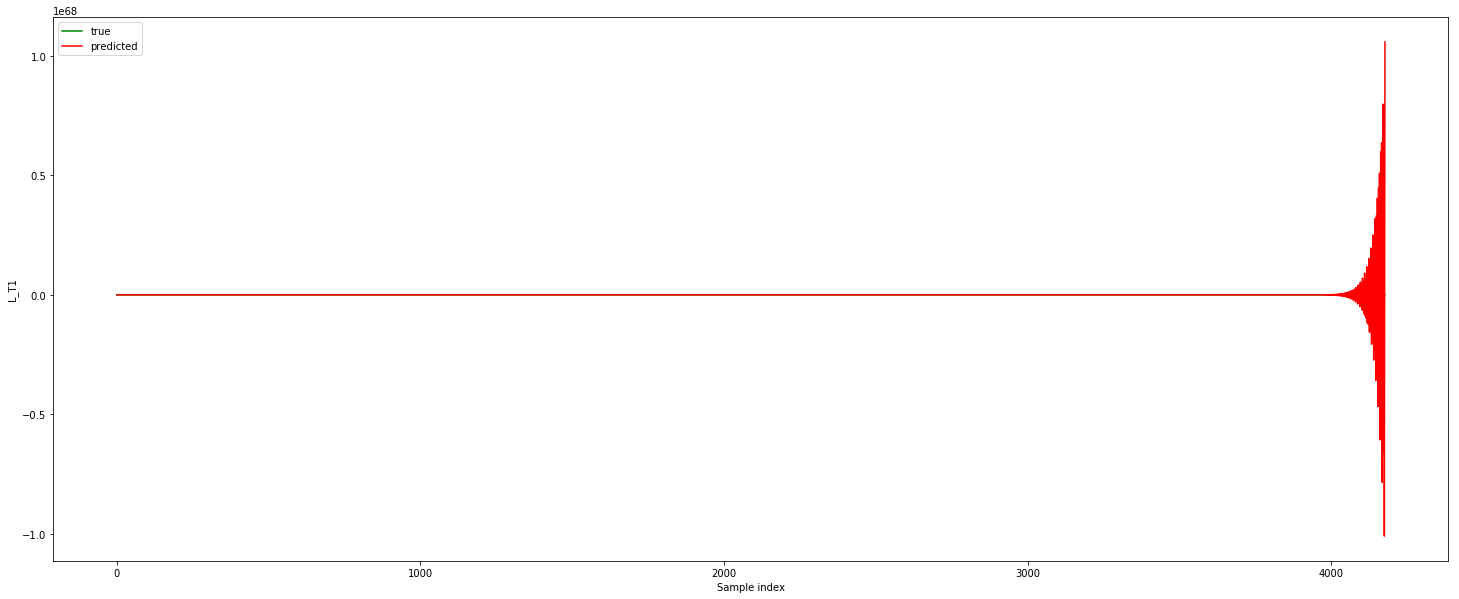

In [42]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

In [43]:
multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.05
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.525      0.525      0.525      0.525      0.5251289  0.5251289
 0.5252578  0.5252578  0.5253867  0.5255156  0.5256445  0.52590231
 0.52603121 0.52616011 0.52616011 0.52616011 0.52628901] 

ind:  16


Confusion matrix:  [[ 492 3675]
 [   0   10]] 

SCM:  0.5013568521031208
Sttd:  1.0
Score:  0.5262890094979648
Accuracy:  0.12018194876705769
Precision:  0.11807055435565154
Recall:  1.0
F1_score:  0.2112041210560206


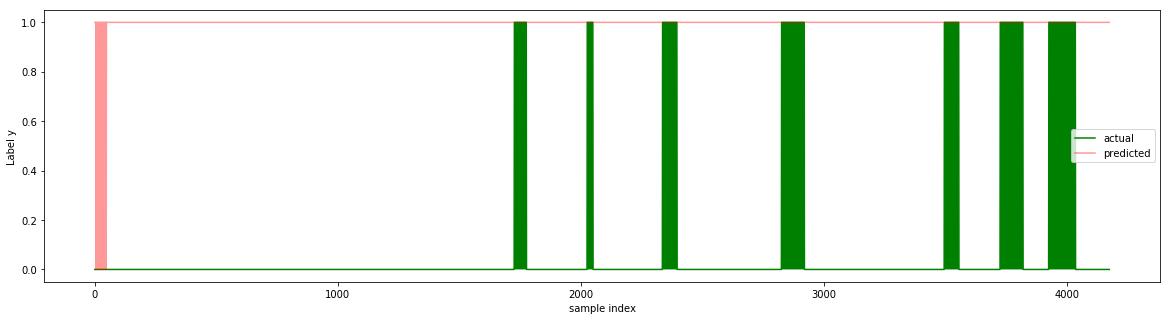

In [44]:
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix: ", cm, "\n")

scm = compute_scm(cm)
print("SCM: ", scm)

sttd = compute_sttd(y2, predicted_labels)
print("Sttd: ", sttd)

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: ", s)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

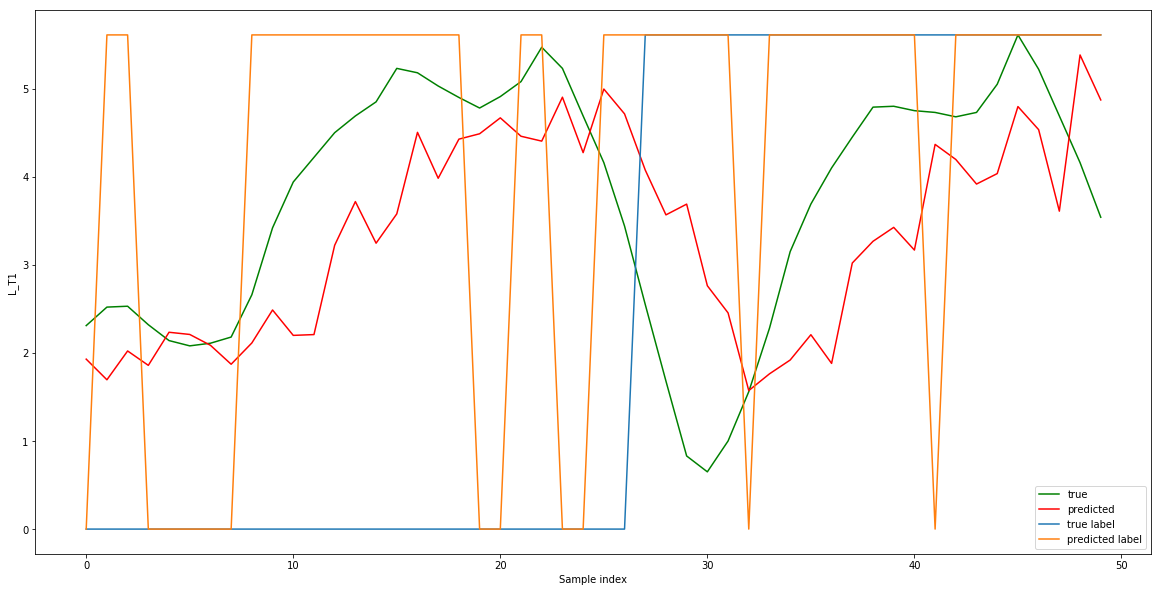

In [24]:
start = 1700
end = 1750

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")